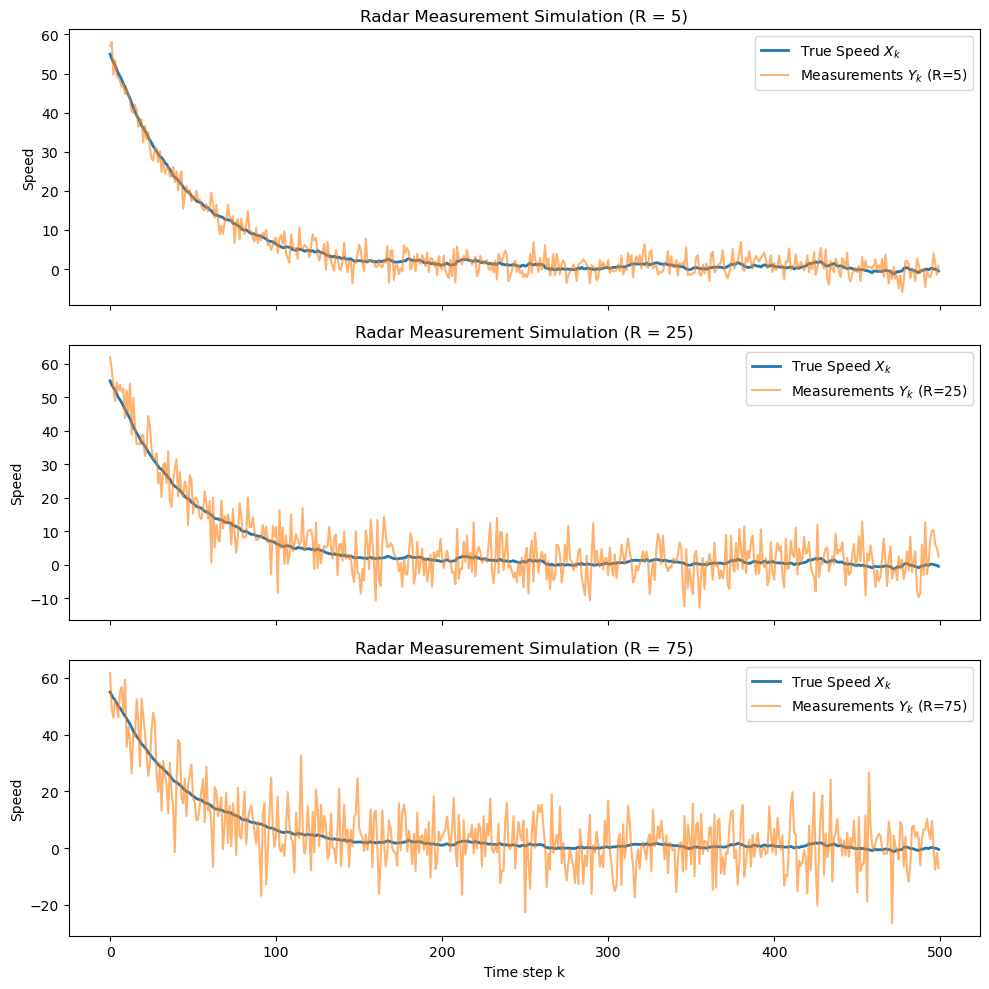

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
N = 500           # time steps
a = 0.98          # state transition
Q = 0.04          # process noise variance
b = 1             # measurement gain
initial_mean = 50
initial_var = 100

# Generate true state X
X = np.zeros(N)
X[0] = np.random.normal(initial_mean, np.sqrt(initial_var))
for k in range(1, N):
    X[k] = a * X[k-1] + np.random.normal(0, np.sqrt(Q))

# Measurement noise scenarios
R_values = [5, 25, 75]
Y_all = {}

for R in R_values:
    V = np.random.normal(0, np.sqrt(R), size=N)
    Y = b * X + V
    Y_all[R] = Y

# Plot results
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
for i, R in enumerate(R_values):
    axs[i].plot(X, label="True Speed $X_k$", linewidth=2)
    axs[i].plot(Y_all[R], label=f"Measurements $Y_k$ (R={R})", alpha=0.6)
    axs[i].set_ylabel("Speed")
    axs[i].set_title(f"Radar Measurement Simulation (R = {R})")
    axs[i].legend(loc="upper right")

axs[-1].set_xlabel("Time step k")
plt.tight_layout()
plt.show()


Problem 3(b): Apply Kalman Filter to Track 

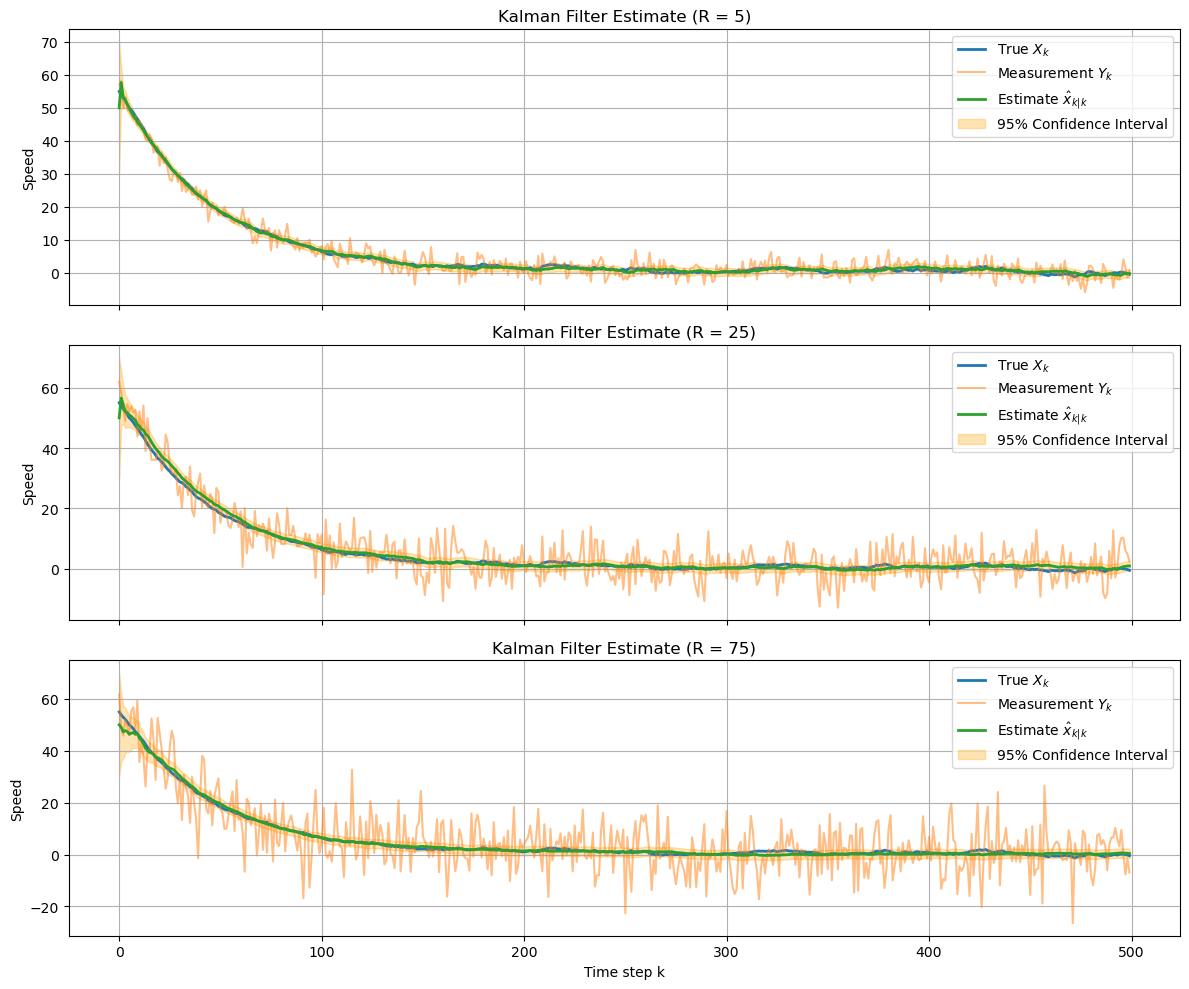

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed(42)
N = 500           # number of time steps
a = 0.98          # state transition coefficient
Q = 0.04          # process noise variance
b = 1             # measurement gain
initial_mean = 50
initial_var = 100

# Generate true state X
X = np.zeros(N)
X[0] = np.random.normal(initial_mean, np.sqrt(initial_var))
for k in range(1, N):
    X[k] = a * X[k-1] + np.random.normal(0, np.sqrt(Q))

# Measurement noise scenarios
R_values = [5, 25, 75]
Y_all = {}

# Generate noisy observations for each R
for R in R_values:
    V = np.random.normal(0, np.sqrt(R), size=N)
    Y = b * X + V
    Y_all[R] = Y

# Kalman filter function
def run_kalman_filter(Y, a, b, Q, R, mu_0, P_0):
    N = len(Y)
    x_est = np.zeros(N)         # Posterior mean estimate \hat{x}_{k|k}
    P_est = np.zeros(N)         # Posterior variance P_{k|k}
    x_pred = np.zeros(N)        # Predicted state \hat{x}_{k|k-1} (optional)

    # Initial conditions
    x_est[0] = mu_0
    P_est[0] = P_0

    for k in range(1, N):
        # Predict
        x_pred[k] = a * x_est[k-1]
        P_pred = a**2 * P_est[k-1] + Q

        # Kalman gain
        K = (P_pred * b) / (b**2 * P_pred + R)

        # Update
        x_est[k] = x_pred[k] + K * (Y[k] - b * x_pred[k])
        P_est[k] = P_pred - K * b * P_pred

    return x_est, P_est

# Initial Kalman filter parameters
mu_0 = 50
P_0 = 100

# Plot estimates for each R on a single figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for i, R in enumerate(R_values):
    Y = Y_all[R]
    x_est, P_est = run_kalman_filter(Y, a, b, Q, R, mu_0, P_0)

    axs[i].plot(X, label="True $X_k$", linewidth=2)
    axs[i].plot(Y, label="Measurement $Y_k$", alpha=0.5)
    axs[i].plot(x_est, label="Estimate $\hat{x}_{k|k}$", linewidth=2)
    axs[i].fill_between(
        range(len(X)),
        x_est - 2 * np.sqrt(P_est),
        x_est + 2 * np.sqrt(P_est),
        color="orange",
        alpha=0.3,
        label="95% Confidence Interval"
    )
    axs[i].set_title(f"Kalman Filter Estimate (R = {R})")
    axs[i].set_ylabel("Speed")
    axs[i].legend(loc="upper right")
    axs[i].grid(True)

axs[-1].set_xlabel("Time step k")
plt.tight_layout()
plt.show()


Problem 3(c): Kalman Filtering with State-Dependent Measurement Noise

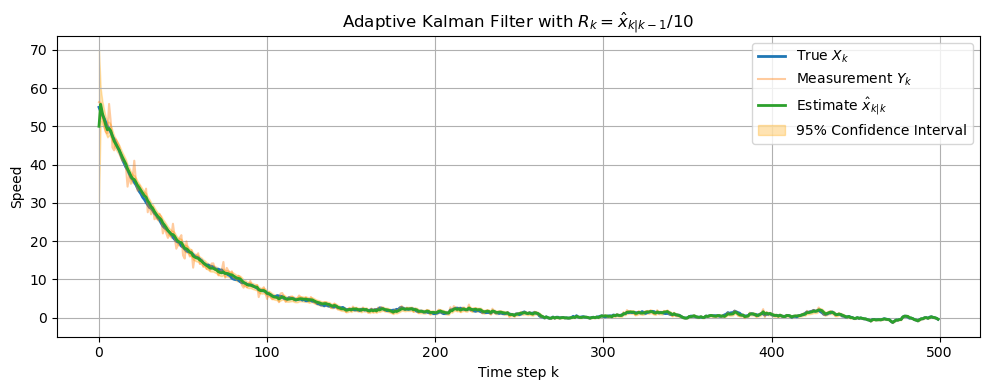

In [ ]:
def run_kalman_v2(Y, a, b, Q, mu_0, P_0):
    N = len(Y)
    x_est = np.zeros(N)        # \hat{x}_{k|k}
    P_est = np.zeros(N)        # P_{k|k}
    x_pred = np.zeros(N)       # \hat{x}_{k|k-1}
    R_vals = np.zeros(N)       # Store R_k values for analysis

    # Initialize
    x_est[0] = mu_0
    P_est[0] = P_0
    R_vals[0] = 1 / 10 * mu_0

    for k in range(1, N):
        # Predict
        x_pred[k] = a * x_est[k-1]
        P_pred = a**2 * P_est[k-1] + Q

        # Estimate R_k from prediction
        R_k = max(0.01, 1/10 * x_pred[k])  # Avoid division by zero or negative R
        R_vals[k] = R_k

        # Kalman gain
        K = (P_pred * b) / (b**2 * P_pred + R_k)

        # Update
        x_est[k] = x_pred[k] + K * (Y[k] - b * x_pred[k])
        P_est[k] = P_pred - K * b * P_pred

    return x_est, P_est, R_vals

# Simulate new noisy measurement using true X
R_true = np.maximum(1e-3, 1/10 * X)
V = np.random.normal(0, np.sqrt(R_true))
Y_dynamic = b * X + V

# Run adaptive Kalman filter
x_est_dyn, P_est_dyn, R_used = run_kalman_v2(Y_dynamic, a, b, Q, mu_0, P_0)

# Plot results
plt.figure(figsize=(10, 4))
plt.plot(X, label="True $X_k$", linewidth=2)
plt.plot(Y_dynamic, label="Measurement $Y_k$", alpha=0.4)
plt.plot(x_est_dyn, label="Estimate $\hat{x}_{k|k}$", linewidth=2)
plt.fill_between(
    range(len(X)),
    x_est_dyn - 2 * np.sqrt(P_est_dyn),
    x_est_dyn + 2 * np.sqrt(P_est_dyn),
    color="orange",
    alpha=0.3,
    label=r"95% Confidence Interval"
)
plt.title("Adaptive Kalman Filter with $R_k = \hat{x}_{k|k-1}/10$")
plt.xlabel("Time step k")
plt.ylabel("Speed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
